In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.misc import imread
%matplotlib inline
from mpl_toolkits.basemap import Basemap

import maxflow
import networkx as nx

# imgroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

$E(\mathbf{x}) = \sum_i D_i(x_i) + \sum_{(i,j)\in\mathcal{C}} K|x_i - x_j|$

$\mathbf{x} \in \{0,1\}^N$

$D_i(x_i) = \begin{cases} p_i & \textrm{if } x_i=0\\ 255-p_i & \textrm{if } x_i=1 \end{cases}$

# playing with graph-cut

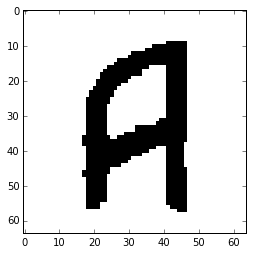

In [21]:
# https://github.com/pmneila/PyMaxflow/tree/master/examples

img = imread(dataroot+"a2.png")

# Create the graph.
g = maxflow.Graph[int](0, 0)
# Add the nodes.
nodeids = g.add_grid_nodes(img.shape)
# Add edges with the same capacities.
g.add_grid_edges(nodeids, 50)
# Add the terminal edges. The image pixels are the capacities
g.add_grid_tedges(nodeids, img, 255-img)

graph = g.get_nx_graph()

# Find the maximum flow.
g.maxflow()
# Get the segments.
sgm = g.get_grid_segments(nodeids)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
plt.imshow(img2, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [14]:
def plot_graph_2d(graph, nodes_shape, plot_weights=True, plot_terminals=True, font_size=7):
    X, Y = np.mgrid[:nodes_shape[0], :nodes_shape[1]]
    aux = np.array([Y.ravel(), X[::-1].ravel()]).T
    positions = {i: aux[i] for i in xrange(25)}
    positions['s'] = (-1, nodes_shape[0] / 2.0 - 0.5)
    positions['t'] = (nodes_shape[1], nodes_shape[0] / 2.0 - 0.5)

    nxgraph = graph.get_nx_graph()
    if not plot_terminals:
        nxgraph.remove_nodes_from(['s', 't'])

    plt.clf()
    nx.draw(nxgraph, pos=positions)

    if plot_weights:
        edge_labels = {}
        for u, v, d in nxgraph.edges(data=True):
            edge_labels[(u,v)] = d['weight']
        nx.draw_networkx_edge_labels(nxgraph,
                                     pos=positions,
                                     edge_labels=edge_labels,
                                     label_pos=0.3,
                                     font_size=font_size)

    plt.axis('equal')
    plt.show()

def plot_graph_3d(graph, nodes_shape, plot_terminal=True, plot_weights=True, font_size=7):
    w_h = nodes_shape[1] * nodes_shape[2]
    X, Y = np.mgrid[:nodes_shape[1], :nodes_shape[2]]
    aux = np.array([Y.ravel(), X[::-1].ravel()]).T
    positions = {i: aux[i] for i in xrange(w_h)}

    for i in xrange(1, nodes_shape[0]):
        for j in xrange(w_h):
            positions[w_h * i + j] = [positions[j][0] + 0.3 * i, positions[j][1] + 0.2 * i]

    positions['s'] = np.array([-1, nodes_shape[1] / 2.0 - 0.5])
    positions['t'] = np.array([nodes_shape[2] + 0.2 * nodes_shape[0], nodes_shape[1] / 2.0 - 0.5])

    nxg = graph.get_nx_graph()
    if not plot_terminal:
        nxg.remove_nodes_from(['s', 't'])

    nx.draw(nxg, pos=positions)
    nx.draw_networkx_labels(nxg, pos=positions)
    if plot_weights:
        edge_labels = dict([((u, v,), d['weight'])
                     for u, v, d in nxg.edges(data=True)])
        nx.draw_networkx_edge_labels(nxg, 
                                     pos=positions,
                                     edge_labels=edge_labels,
                                     label_pos=0.3,
                                     font_size=font_size)
    plt.axis('equal')
    plt.show()

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
C:\Anaconda\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
C:\Anaconda\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


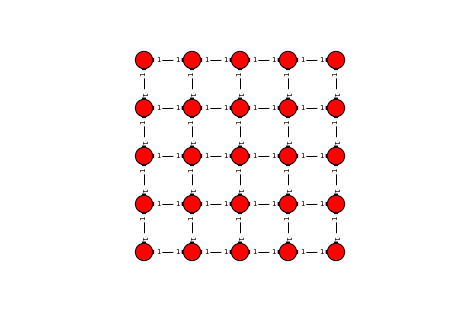

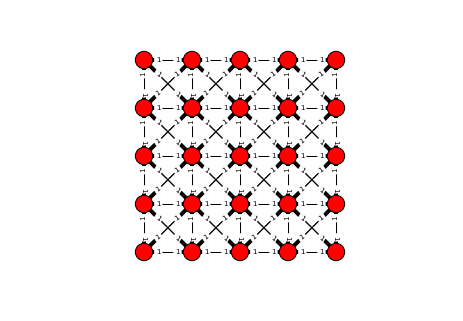

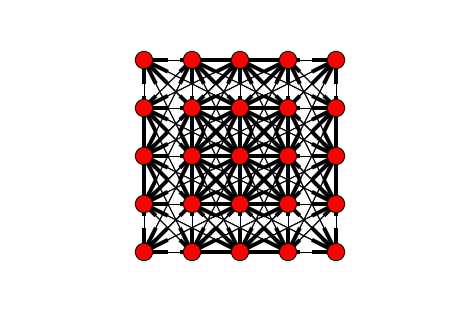

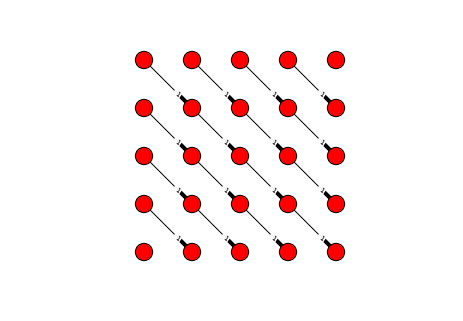

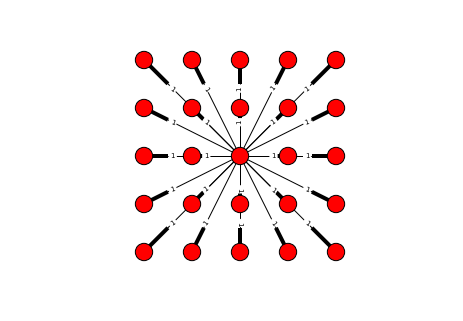

In [17]:
# Standard 4-connected grid
g = maxflow.Graph[int]()
nodeids = g.add_grid_nodes((5, 5))
g.add_grid_edges(nodeids, 1)
# Equivalent to
# structure = maxflow.vonNeumann_structure(ndim=2, directed=False)
# g.add_grid_edges(nodeids, 1,
#                  structure=structure,
#                  symmetric=False)
plot_graph_2d(g, nodeids.shape, plot_terminals=False)

# 8-connected grid
g = maxflow.Graph[int]()
nodeids = g.add_grid_nodes((5, 5))
structure = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [1, 1, 1]])
# Also structure = maxflow.moore_structure(ndim=2, directed=True)
g.add_grid_edges(nodeids, 1, structure=structure, symmetric=True)
plot_graph_2d(g, nodeids.shape, plot_terminals=False)

# 24-connected 5x5 neighborhood
g = maxflow.Graph[int]()
nodeids = g.add_grid_nodes((5, 5))
structure = np.array([[1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1],
                      [1, 1, 0, 1, 1],
                      [1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1]])
g.add_grid_edges(nodeids, 1, structure=structure, symmetric=False)
plot_graph_2d(g, nodeids.shape, plot_terminals=False, plot_weights=False)

# Diagonal, not symmetric
g = maxflow.Graph[int]()
nodeids = g.add_grid_nodes((5, 5))
structure = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 0, 1]])
g.add_grid_edges(nodeids, 1, structure=structure, symmetric=False)
plot_graph_2d(g, nodeids.shape, plot_terminals=False)

# Central node connected to every other node
g = maxflow.Graph[int]()
nodeids = g.add_grid_nodes((5, 5)).ravel()

central_node = nodeids[12]
rest_of_nodes = np.hstack([nodeids[:12], nodeids[13:]])

nodeids = np.empty((2, 24), dtype=np.int_)
nodeids[0] = central_node
nodeids[1] = rest_of_nodes

structure = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 1, 0]])
g.add_grid_edges(nodeids, 1, structure=structure, symmetric=False)
plot_graph_2d(g, (5, 5), plot_terminals=False)

In [2]:
cats_boston = ['Agassiz','Allston','Area 2/MIT','BROOKLINE_02445','BROOKLINE_02446','Back Bay',  
        'Bay Village','Beacon Hill','Brighton','Cambridgeport','Charlestown','Chinatown',
        'Dorchester','Downtown','EVERETT_02149','East Boston','East Cambridge','Fenway',
        'Jamaica Plain','Leather District','Longwood Medical Area','MEDFORD_02155','Mid-Cambridge',
        'Mission Hill','Neighborhood Nine','North Cambridge','North End','Riverside','Roxbury',
        'SOMERVILLE_02143','SOMERVILLE_02144','SOMERVILLE_02145','South Boston','South Boston Waterfront',
        'South End','The Port','WATERTOWN_02472','Wellington-Harrington','West Cambridge','West End']

# Reading features

In [3]:
df = pd.read_csv(dataroot+'deep_features_boston.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,2.0897,0,0,0,0,0.54691,0,0,0.00000,1.338,...,0.47297,0.0000,0,0,0.0000,0.0000,0,0,0.000000,0
1,0.0000,0,0,0,0,0.00000,0,0,0.00000,0.000,...,0.22579,0.0000,0,0,0.0000,0.0000,0,0,0.000000,0
2,1.1076,0,0,0,0,0.00000,0,0,0.97727,0.000,...,0.00000,0.0000,0,0,0.0000,0.0000,0,0,0.000000,0
3,0.0000,0,0,0,0,0.00000,0,0,0.21260,0.000,...,1.05530,1.1426,0,0,2.9811,1.0855,0,0,0.001122,0
4,0.0000,0,0,0,0,0.00000,0,0,0.00000,0.000,...,0.49824,0.0000,0,0,0.0000,1.0555,0,0,0.000000,0


In [4]:
df_label = pd.read_csv(dataroot+'deep_test_stats_boston.csv')
df_label.head()

,lat,lng,dir,label,label_num,ownScore,predLabel,predLabel_num,bestScore
0,42.300087,-71.073887,0,Dorchester,13,0.008344,Riverside,28,0.481820
1,42.300087,-71.073887,3,Dorchester,13,0.226555,Dorchester,13,0.226555
2,42.300135,-71.099670,0,Roxbury,29,0.049399,BROOKLINE_02445,4,0.200370
3,42.300516,-71.084763,1,Dorchester,13,0.034693,Riverside,28,0.262675
4,42.300516,-71.084763,3,Dorchester,13,0.067623,Riverside,28,0.345267


In [5]:
df[['lat','lng']] = df_label[['lat','lng']]

In [6]:
from sklearn import preprocessing 
X_normalized = preprocessing.normalize(df, norm='l2')
X_normalized[:,-2:] = X_normalized[:,-2:] #* 1000
X_normalized[:,-2:]

array([[ 0.48419339, -0.8135564 ],
       [ 0.48738604, -0.81892078],
       [ 0.48121893, -0.80885101],
       ..., 
       [ 0.46906427, -0.78626793],
       [ 0.41776275, -0.7003756 ],
       [ 0.42064676, -0.70521062]])

# Clustering

In [7]:
from sklearn import cluster, datasets
from sklearn.cluster import SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# num_cat = 21
# spectral = SpectralClustering(n_clusters=num_cat,
#                                       eigen_solver='arpack',
#                                       affinity="rbf")
# y_pred = spectral.fit_predict(X)
# y_pred

bw = estimate_bandwidth(X_normalized[:,-2:], quantile=0.1, n_samples=500)

ms = MeanShift(bin_seeding=True, bandwidth=bw, min_bin_freq=1)

In [8]:
ypred = ms.fit_predict(X_normalized[:,-2:])

In [9]:
bw, np.unique(ypred)

(0.011828579416056589,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64))

In [10]:
y_preds = pd.DataFrame()
X = X_normalized
for num_cat in range(2,7):
    print num_cat
    spectral = cluster.SpectralClustering(n_clusters=num_cat,
                                      eigen_solver='arpack',
                                      affinity="rbf")
    y_pred = spectral.fit_predict(X)
    y_preds['cat_from_'+str(num_cat)] = y_pred
    
y_preds.head()

2
3
4
5
6


,cat_from_2,cat_from_3,cat_from_4,cat_from_5,cat_from_6
0,0,1,1,2,2
1,0,0,3,1,5
2,0,0,3,0,2
3,0,0,3,0,1
4,0,0,3,0,1


# Binning visualization

In [12]:
def most_frequent_label(arr):
    unique = np.unique(arr)
    count = [np.sum([arr == ele]) for ele in unique]
    return unique[np.argsort(count)[::-1]][0]

In [13]:
[np.sum([ y_preds['cat_from_4'] == ele]) for ele in np.unique( y_preds['cat_from_4'] )]

[982, 1947, 1114, 1595]

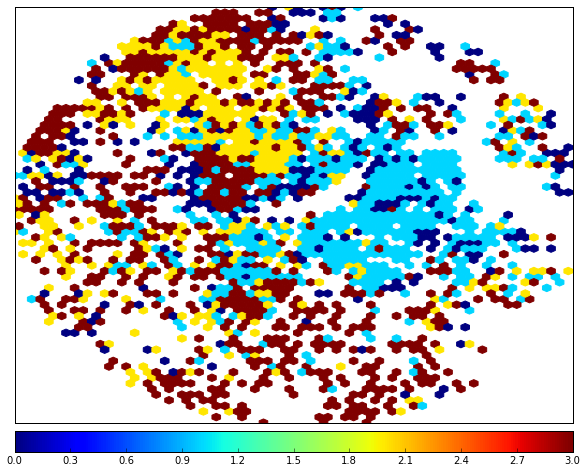

In [19]:
# https://basemaptutorial.readthedocs.org/en/latest/plotting_data.html

bounds = [np.min(df['lng']), np.max(df['lng']), np.min(df['lat']), np.max(df['lat'])]
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(10,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(resolution = 'l', 
              epsg=4326,
              llcrnrlon = bounds[0], llcrnrlat = bounds[2], urcrnrlon = bounds[1], urcrnrlat = bounds[3])

map.hexbin(df['lng'].values, df['lat'].values, C=y_preds['cat_from_4'], reduce_C_function = most_frequent_label, gridsize = 65)

map.colorbar(location='bottom')

plt.show()

In [42]:
df_label = pd.read_csv(dataroot+'test_stats_boston.csv')
clusters_df = df_label.join(y_preds)
clusters_df.to_csv(dataroot+'clusters_boston.csv')